In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from datetime import datetime
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models import EfficientNet

from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss
# from models_package.models import Teacher, Student

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
from utils.loss_functions import DKDLoss
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from models_package.models import Teacher, Student
from torchvision import datasets, transforms, models
import models_package
import time
from datetime import datetime
import json
import random
import logging
from pathlib import Path
import argparse
import warnings
from torch.utils.tensorboard import SummaryWriter
import pdb
import time
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset, Dataset, DataLoader
from PIL import Image
from pathlib import Path
from collections import OrderedDict
import os, shutil

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
# new libraries
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof
import boto3
import io
import models_package
from utils.loss_functions import DKDLoss, DirectNormLoss, KDLoss
from utils.compare_tools import compare_model_size, compare_inference_time, compare_performance_metrics, plot_comparison
from utils.misc_tools import colorstr, Save_Checkpoint, AverageMeter, epoch_loop_reviewkd
from utils.misc_tools import best_LR, best_LR_nd, best_LR_wider, train_teacher, train_teacher_wider, train_teacher_efficientnet, train_teacher_efficientnet_wider, retrieve_teacher_class_weights, new_teacher_class_weights


In [3]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [56]:
# Hyperparameters
learning_rate = 0.001 # 0.096779
epochs = 300
epochs_pretrain = 3
epochs_optimal_lr = 5
patience_teacher = 20
patience_student = 10
temperature = 4.0
alpha = 0.9
momentum = 0.9
step_size = 30
gamma = 0.1
batch_size = 64
num_workers = 4

# set to true to use stratified sampling
stratified_sampling_flag = False

# list of lambda values to loop through for grid search
# lmda_list_student = [10,5,3,0.5,0]
# lmda_list_teacher = [10,5,3,0.5,0]
lmda_list_student = [4,0]
lmda_list_teacher = [4,0]

# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16
class_names_new = [f"Class {label}" for label in range(num_classes)]

# Create directory and file path to save all outputs
output_dir = f'./runs_{datetime.now().strftime("%Y_%m_%d_%H_%M")}'
os.makedirs(output_dir, exist_ok=True)

In [5]:
# Assuming your JSON file is named 'your_file.json'
file_path = './WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [6]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water_Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(num_classes):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [7]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)//self.batch_size

In [8]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        
        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [9]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [10]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [11]:
# train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider')
train_dataset = DataSet(train_file, augs = [], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')

if stratified_sampling_flag:
    trainloader = DataLoader(train_dataset, 
                             batch_sampler=StratifiedBatchSampler(torch.tensor([train_dataset[i]['label'] for i in range(len(train_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_sampler=StratifiedBatchSampler(torch.tensor([test_dataset[i]['label'] for i in range(len(test_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)

Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [12]:
len(train_dataset)

10324

In [13]:
# def print_batch_class_counts(data_loader, label_mapping, num_batches=5):
#     for i, batch in enumerate(data_loader):
#         if i >= num_batches:
#             break

#         # Extract labels from the batch
#         labels = batch['label']

#         # Count occurrences of each class
#         class_counts = torch.bincount(labels)

#         # Map class counts to class names
#         class_counts_with_names = {label_mapping.get(j, f"Unknown Class {j}"): class_counts[j].item() for j in range(len(class_counts))}

#         # Print class counts and total observations
#         print(f"Batch {i + 1}:")
#         for class_name, count in class_counts_with_names.items():
#             print(f"    {class_name}: {count}")
#         print(f"Total Observations: {len(labels)}\n")

# print_batch_class_counts(trainloader, new_label_mapping)


# Start Training Process

In [14]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)
    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix


In [15]:
##### HELPER FUNCTION FOR FEATURE EXTRACTION

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [16]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')
teacher_model.classifier = nn.Linear(1536, num_classes)
student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
student_model.classifier = nn.Linear(1280, num_classes)

# Load teacher
# teacher_model = torch.load('teacher_model_ckd_wider.pth')
# teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider.pth'))
# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_wider.pth')
# # Load the studnet
# student_model = torch.load('student_model_ckd_prof.pth')
# student_model.load_state_dict(torch.load('student_model_weights_ckd_prof_checkpoint.pth'))
# student_model = student_model.to(device)


This is the initialization of the 2-layer Adversary Perceptron. It is initialized with the number of classes*2, which represents the predicted labels (y_hat) and the true labels (y). The output of the final layer is a regression output, which is intended to predict the strength of gender (continuous number where anything past 0.5 is more male).


In [17]:
class Adversary(nn.Module):
    def __init__(self, input_size=num_classes):
        super(Adversary, self).__init__()

        self.a1 = nn.Linear(input_size*2, 16)
        self.a2 = nn.Linear(16, 1)  # Output size 1 for regression
        nn.init.xavier_normal_(self.a1.weight)
        nn.init.kaiming_normal_(self.a2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, input_ids):
        adversary = F.relu(self.a1(input_ids))
        adversary_output = F.sigmoid(self.a2(adversary))  # Linear activation for regression
        return adversary_output

# Instantiate the Adversary
adv = Adversary()

In [18]:
def pretrain_student(student, teacher, trainloader, criterion, optimizer, device, alpha, temperature, epochs_pretrain, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
                
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        student_epoch_losses.append(epoch_loss)


In [19]:
def pretrain_teacher(teacher, trainloader, criterion, optimizer, device, epochs_pretrain, patience=patience_student):
    teacher.to(device)
    teacher.train()  # Set the model to training mode
    best_val_loss = float('inf')  
    patience_counter = 0 
    teacher_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            teacher_outputs = teacher(inputs)

            ce_loss = criterion(teacher_outputs, labels)
                
            loss = ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        teacher_epoch_losses.append(epoch_loss)


In [20]:
def pretrain_adversary(adv, student, adversary_optimizer, trainloader, adv_criterion, device, epochs_pretrain):

  for epoch in range(epochs_pretrain):
    epoch_loss = 0
    epoch_batches = 0
    for i, data in enumerate(tqdm(trainloader)): # starting from the 0th batch
        # get the inputs and labels
        adv.train()
        adv.to(device)
        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)
        student = student.to(device)
        adversary_optimizer.zero_grad()
        student_output = student(inputs)
        one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
        concatenated_output = torch.cat((student_output, one_hot_labels), dim=1)
        adversary_output = adv(concatenated_output)
        adversary_loss = adv_criterion(adversary_output, targets) # compute loss
        adversary_loss.backward() # back prop
        adversary_optimizer.step()
        epoch_loss += adversary_loss.item()
        epoch_batches += 1

    print("Average Pretrain Adversary epoch loss: ", epoch_loss/epoch_batches)


In [21]:
# Optimizer and scheduler for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

# Instantiate the model and the loss function
criterion_clf = nn.CrossEntropyLoss()
adv_criterion = nn.MSELoss()


In [22]:
best_lr_student = 0.09999999999999999
best_lr_teacher = 9.999999999999999e-05

In [23]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Val Loss Curve')
    plt.show()

In [24]:
# This is the adversary training function, where we input the student outputs, 
# with the true labels into the adversary model created previously.
def train_adversary(adv, model, optimizer, trainloader, criterion, epochs):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_batches = 0
        for i, data in enumerate(tqdm(trainloader)):
            # get the inputs and labels
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            model.eval()
            model.to(device)
            adv.train()
            adv.to(device)
            optimizer.zero_grad()
            # output the student model, join with ohe labels. 
            model_output = model(inputs)
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((model_output, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)

            adversary_loss = criterion(adversary_output, targets)
            adversary_loss.backward()
            epoch_loss += adversary_loss.item()
            epoch_batches += 1
            optimizer.step()
        epoch_loss/=epoch_batches
        print("Average Adversary epoch loss:", epoch_loss)

In [25]:
# Function to train the teacher model
def train_teacher(model_name, dataset, model, adv, trainloader, criterion, adv_criterion, optimizer, optimizer_adv, device, 
                  epochs, lmda, patience=patience_teacher):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []
    val_disparities = []
    val_accuracies = []
    best_total_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        adv.train()
        model.to(device)
        adv.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
        
            # Forward pass for teacher model
            optimizer.zero_grad()
            outputs = model(inputs)
            classification_loss = criterion(outputs, labels)
        
            # Forward pass for adversary model
            optimizer_adv.zero_grad()
            with torch.no_grad():
                teacher_outputs_detached = outputs.detach()
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((teacher_outputs_detached, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)
            adversary_loss = adv_criterion(adversary_output, targets)
        
            # Calculate the total loss by combining classification and adversary loss
            if lmda != 0:
                total_loss = classification_loss + classification_loss/adversary_loss - lmda * adversary_loss
            else:
                total_loss = classification_loss
                
            total_loss.backward()
        
            optimizer.step()
            optimizer_adv.step()
        
            running_loss += total_loss.item()
            epoch_loss += total_loss.item()
            num_batches += 1

        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)

        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                val_outputs = model(val_inputs)
                with torch.no_grad():
                    teacher_outputs_detached_val = val_outputs.detach()                
                one_hot_labels_val = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                concatenated_output_val = torch.cat((teacher_outputs_detached_val, one_hot_labels_val), dim=1)
                adversary_output_val = adv(concatenated_output_val)
                adversary_loss_val = adv_criterion(adversary_output_val, val_targets)
                
                # Compute validation loss
                val_ce_loss = criterion(val_outputs, val_labels)

                if lmda !=0:
                    val_loss = val_ce_loss + val_ce_loss/adversary_loss_val - lmda * adversary_loss_val
                else:
                    val_loss = val_ce_loss
                    
                total_val_loss += val_loss.item()

                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1

                # Compute recall differences for gender
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]

            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches
            
            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")
        
        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0 

            # checkpoint
            save_path = './weights/'

            # save locally
            model_save_path = os.path.join(save_path, model_name)
            
            os.makedirs(model_save_path, exist_ok=True)
        
            model_save_name = os.path.join(model_save_path, f'checkpoint_lmda_{lmda}.pth')
            mode_weights_name = os.path.join(model_save_path, f'weights_lmda_{lmda}.pth')
            
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity

            torch.save(model.state_dict(), mode_weights_name)
            torch.save(model, model_save_name)

            # push to s3
            session = boto3.session.Session()
            s3 = session.client('s3')
            
            bucket_name = '210bucket' 
            
            # Teacher Model
            #### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
            teacher_model_weights_path = f'weights/teacher_model_weights_{model_name}_{dataset}_{lmda}.pth'
            teacher_model_path = f'models/testing_teacher_model_{model_name}_{dataset}_{lmda}.pth'
            
            # Save state dict to buffer
            teacher_model_weights_buffer = io.BytesIO()
            torch.save(teacher_model.state_dict(), teacher_model_weights_buffer)
            teacher_model_weights_buffer.seek(0)
            
            # Save entire model to buffer
            teacher_model_buffer = io.BytesIO()
            torch.save(teacher_model, teacher_model_buffer)
            teacher_model_buffer.seek(0)
            
            # Upload to S3
            s3.put_object(Bucket=bucket_name, Key=teacher_model_weights_path, Body=teacher_model_weights_buffer)
            s3.put_object(Bucket=bucket_name, Key=teacher_model_path, Body=teacher_model_buffer)
            print('teacher weights and architecture saved and exported to S3')


        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        file_path = os.path.join(output_dir, f'teacher_validation_{lmda}.txt')
        
        # Append data to the text file
        with open(file_path, 'a') as file:
            file.write(f'********Epoch: {epochs}***********')
            
            file.write("Teacher Val Accuracies:\n")
            for accuracy in val_accuracies:
                file.write(f"{accuracy}\n")
        
            file.write("\nTeacher Val Disparities:\n")
            for disparity in val_disparities:
                file.write(f"{disparity}\n")

            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        
        print(f"Data has been appended to {file_path}")
    
    plot_loss_curve(val_losses)
    print("Finished Training Teacher")
    return val_disparities


## Extract Teacher Class Mean Embeddings

In [26]:
def get_emb_fea(model, dataloader, batch_size):
    ''' Used to extract the feature embeddings in a teacher model '''
    
    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()
        return hook

    
    model.eval()
    model.avgpool.register_forward_hook(get_features('feats'))

    EMB = {}


    with torch.no_grad():
        for index, data in enumerate(tqdm(trainloader)):
            FEATS = []
            features = {}
            
            inputs = data['img'].to(device)
            labels = data['label'].to(device)

            curr_batch_size = len(inputs)

            # compute output
            # emb_fea, logits = model(images, embed=True)
            outputs = model(inputs)
            # feats = features['feats'].cpu().numpy()
            # emb_fea = feats.flatten()
            FEATS.append(features['feats'].cpu().numpy())
            emb_fea = np.concatenate(FEATS)
            # reshape embedding features to flatten 
            emb_fea = emb_fea.reshape((curr_batch_size, emb_fea.shape[1]))


            for emb, i in zip(emb_fea, labels):
                i = i.item()
                emb_size = len(emb) 
                if str(i) in EMB:
                    for j in range(emb_size):
                        EMB[str(i)][j].append(round(emb[j].item(), 4))
                else:
                    EMB[str(i)] = [[] for _ in range(emb_size)]
                    for j in range(emb_size):
                        EMB[str(i)][j].append(round(emb[j].item(), 4))

    for key, value in EMB.items():
        for i in range(emb_size):
            EMB[key][i] = round(np.array(EMB[key][i]).mean(), 4)

    return EMB


def retrieve_teacher_class_weights(model_name, model, model_weight_path, num_class, data_name, dataloader, batch_size, bucket_name, lmda):
    ''' Use the extracted feature embeddings to create a json of class means for teacher'''

    session = boto3.session.Session()
    s3 = session.client('s3')

    teacher_model_weights_buffer = io.BytesIO()
    s3.download_fileobj(bucket_name, model_weight_path, teacher_model_weights_buffer)
    teacher_model_weights_buffer.seek(0)  

    # Load the model
    # model = models_package.__dict__[model_name](num_class=num_class)
    checkpoint = torch.load(teacher_model_weights_buffer)
    # print("Keys in checkpoint:", checkpoint.keys())
    print("model is loaded properly")

    new_state_dict = OrderedDict()
    for k, v in checkpoint.items():
        name = k[7:] if k.startswith('module.') else k
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    model.eval()

    for param in model.parameters():
        param.requires_grad = False
    
    model = model.cuda()

    # emb = get_emb_fea(model=model, dataloader=dataloader, batch_size=batch_size)
    # emb_json = json.dumps(emb, indent=4)
    # with open("./class_means/{}_embedding_fea/{}.json".format(data_name, model_name), 'w', encoding='utf-8') as f:
    #     f.write(emb_json)

    emb = get_emb_fea(model=model, dataloader=dataloader, batch_size=batch_size)
    emb_json = json.dumps(emb, indent=4)

    # Create the directory if it doesn't exist
    output_dir = "./class_means/{}_embedding_fea".format(data_name)
    os.makedirs(output_dir, exist_ok=True)

    with open("{}/{}_lmda{}.json".format(output_dir, model_name, lmda), 'w', encoding='utf-8') as f:
        f.write(emb_json)

In [27]:
##### SET VARIABLES ####
data_name = 'WIDER'
model_name = 'efficientnetb3'
save_dir = './run/WIDER/disparity/KD++'
bucket_name = '210bucket' 

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.98it/s]


*****Epoch 1/300*****
*****Train Loss:  2.704193 Val Loss:  1.226652*****
*****Validation Accuracy: 52.84%*****
*****Total Avg Disparity: 0.1994175531311332*****

Class Team_Sports: Recall Difference = 0.07063783116838596
Class Celebration: Recall Difference = -0.06638736706413151
Class Parade: Recall Difference = 0.02850105559465177
Class Waiter_Or_Waitress: Recall Difference = -0.14410163339382936
Class Individual_Sports: Recall Difference = -0.11274987810823989
Class Surgeons: Recall Difference = 0.05128205128205129
Class Spa: Recall Difference = 0.8775510204081632
Class Law_Enforcement: Recall Difference = 0.28162593389894897
Class Business: Recall Difference = -0.05775788576300084
Class Dresses: Recall Difference = -0.6144781144781145
Class Water_Activities: Recall Difference = 0.14613299979153627
Class Picnic: Recall Difference = -0.19642857142857145
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.054266734798160424
Class Performance_And_Entertainment

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 2/300*****
*****Train Loss: -0.693440 Val Loss: -0.489576*****
*****Validation Accuracy: 61.88%*****
*****Total Avg Disparity: 0.17742693102378432*****

Class Team_Sports: Recall Difference = 0.11682718122722224
Class Celebration: Recall Difference = -0.08153399935546252
Class Parade: Recall Difference = 0.05465634529673946
Class Waiter_Or_Waitress: Recall Difference = -0.033756805807622414
Class Individual_Sports: Recall Difference = -0.1810092637737689
Class Surgeons: Recall Difference = 0.05860805860805868
Class Spa: Recall Difference = 0.4693877551020408
Class Law_Enforcement: Recall Difference = 0.20868684310497654
Class Business: Recall Difference = 0.004475703324808067
Class Dresses: Recall Difference = -0.6206509539842875
Class Water_Activities: Recall Difference = 0.16322701688555352
Class Picnic: Recall Difference = -0.5357142857142857
Class Rescue: Recall Difference = -0.03317901234567905
Class Cheering: Recall Difference = 0.009504343382728653
Class Performance_A

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.94it/s]


*****Epoch 3/300*****
*****Train Loss: -2.169476 Val Loss: -1.274889*****
*****Validation Accuracy: 64.68%*****
*****Total Avg Disparity: 0.17696709227947782*****

Class Team_Sports: Recall Difference = 0.11982040648455972
Class Celebration: Recall Difference = -0.058545493608336
Class Parade: Recall Difference = 0.02334037063101102
Class Waiter_Or_Waitress: Recall Difference = -0.04428312159709624
Class Individual_Sports: Recall Difference = -0.15053632374451487
Class Surgeons: Recall Difference = -0.00439560439560438
Class Spa: Recall Difference = 0.2857142857142857
Class Law_Enforcement: Recall Difference = 0.2921362542737749
Class Business: Recall Difference = -0.020460358056266004
Class Dresses: Recall Difference = -0.6453423120089787
Class Water_Activities: Recall Difference = 0.16812591202835114
Class Picnic: Recall Difference = -0.6428571428571428
Class Rescue: Recall Difference = 0.07793209876543217
Class Cheering: Recall Difference = 0.002963719979560575
Class Performance_And

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.94it/s]


*****Epoch 4/300*****
*****Train Loss: -3.115644 Val Loss: -1.398070*****
*****Validation Accuracy: 65.28%*****
*****Total Avg Disparity: 0.16542587301407222*****

Class Team_Sports: Recall Difference = 0.09951902754452702
Class Celebration: Recall Difference = -0.05816951337415416
Class Parade: Recall Difference = 0.06040347173352101
Class Waiter_Or_Waitress: Recall Difference = -0.015607985480943887
Class Individual_Sports: Recall Difference = -0.14196326994961805
Class Surgeons: Recall Difference = -0.11575091575091578
Class Spa: Recall Difference = 0.2857142857142857
Class Law_Enforcement: Recall Difference = 0.17892870710396358
Class Business: Recall Difference = -0.052003410059676014
Class Dresses: Recall Difference = -0.548260381593715
Class Water_Activities: Recall Difference = 0.1424848863873256
Class Picnic: Recall Difference = -0.6071428571428571
Class Rescue: Recall Difference = 0.0524691358024692
Class Cheering: Recall Difference = 0.008584568216658095
Class Performance_An

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.96it/s]


*****Epoch 5/300*****
*****Train Loss: -3.729601 Val Loss: -1.322326*****
*****Validation Accuracy: 65.31%*****
*****Total Avg Disparity: 0.17349585002437196*****

Class Team_Sports: Recall Difference = 0.11069221190206902
Class Celebration: Recall Difference = -0.04452680201955106
Class Parade: Recall Difference = -0.021932911095472796
Class Waiter_Or_Waitress: Recall Difference = -0.030852994555354063
Class Individual_Sports: Recall Difference = -0.15220217779944745
Class Surgeons: Recall Difference = -0.06446886446886457
Class Spa: Recall Difference = 0.2857142857142857
Class Law_Enforcement: Recall Difference = 0.2153982525009498
Class Business: Recall Difference = -0.022591645353793766
Class Dresses: Recall Difference = -0.6268237934904601
Class Water_Activities: Recall Difference = 0.13393787784031674
Class Picnic: Recall Difference = -0.6428571428571428
Class Rescue: Recall Difference = -0.0015432098765432167
Class Cheering: Recall Difference = -0.052120592743996
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 6/300*****
*****Train Loss: -4.229210 Val Loss: -1.213882*****
*****Validation Accuracy: 65.80%*****
*****Total Avg Disparity: 0.17448858728576438*****

Class Team_Sports: Recall Difference = 0.0981709337263369
Class Celebration: Recall Difference = -0.04237834353851122
Class Parade: Recall Difference = -0.0059817030260379545
Class Waiter_Or_Waitress: Recall Difference = 0.00834845735027212
Class Individual_Sports: Recall Difference = -0.15220217779944734
Class Surgeons: Recall Difference = -0.14432234432234436
Class Spa: Recall Difference = 0.2857142857142857
Class Law_Enforcement: Recall Difference = 0.2099531467645942
Class Business: Recall Difference = -0.05093776641091219
Class Dresses: Recall Difference = -0.542087542087542
Class Water_Activities: Recall Difference = 0.1632270168855534
Class Picnic: Recall Difference = -0.5714285714285713
Class Rescue: Recall Difference = -0.04706790123456778
Class Cheering: Recall Difference = -0.13306080735820136
Class Performance_An

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 7/300*****
*****Train Loss: -4.566689 Val Loss: -1.066718*****
*****Validation Accuracy: 65.89%*****
*****Total Avg Disparity: 0.16196482117960898*****

Class Team_Sports: Recall Difference = 0.08644937222241267
Class Celebration: Recall Difference = -0.06789128800085942
Class Parade: Recall Difference = 0.001055594651653724
Class Waiter_Or_Waitress: Recall Difference = -0.02323049001814903
Class Individual_Sports: Recall Difference = -0.14029741589468547
Class Surgeons: Recall Difference = -0.08424908424908423
Class Spa: Recall Difference = 0.2448979591836734
Class Law_Enforcement: Recall Difference = 0.2099531467645942
Class Business: Recall Difference = -0.0390025575447569
Class Dresses: Recall Difference = -0.505050505050505
Class Water_Activities: Recall Difference = 0.151031894934334
Class Picnic: Recall Difference = -0.6428571428571428
Class Rescue: Recall Difference = -0.013888888888888895
Class Cheering: Recall Difference = -0.11364333163004597
Class Performance_And

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.97it/s]


*****Epoch 8/300*****
*****Train Loss: -4.732870 Val Loss: -0.776570*****
*****Validation Accuracy: 65.37%*****
*****Total Avg Disparity: 0.17260901313366578*****

Class Team_Sports: Recall Difference = 0.09093921010841866
Class Celebration: Recall Difference = -0.04919969921581263
Class Parade: Recall Difference = 0.03553835327234334
Class Waiter_Or_Waitress: Recall Difference = -0.05480943738656996
Class Individual_Sports: Recall Difference = -0.10633024540874358
Class Surgeons: Recall Difference = -0.1186813186813187
Class Spa: Recall Difference = 0.2448979591836734
Class Law_Enforcement: Recall Difference = 0.1885526149170571
Class Business: Recall Difference = -0.020460358056266004
Class Dresses: Recall Difference = -0.542087542087542
Class Water_Activities: Recall Difference = 0.11444652908067565
Class Picnic: Recall Difference = -0.6428571428571429
Class Rescue: Recall Difference = -0.14197530864197533
Class Cheering: Recall Difference = -0.10873786407766994
Class Performance_An

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 9/300*****
*****Train Loss: -4.881103 Val Loss: -0.713829*****
*****Validation Accuracy: 65.45%*****
*****Total Avg Disparity: 0.17425131289082202*****

Class Team_Sports: Recall Difference = 0.10510561972329824
Class Celebration: Recall Difference = -0.016489418841980852
Class Parade: Recall Difference = 0.05207600281491909
Class Waiter_Or_Waitress: Recall Difference = -0.0021778584392015965
Class Individual_Sports: Recall Difference = -0.1368844466114092
Class Surgeons: Recall Difference = -0.06739926739926738
Class Spa: Recall Difference = 0.22448979591836737
Class Law_Enforcement: Recall Difference = 0.17221729770799044
Class Business: Recall Difference = -0.1042199488491049
Class Dresses: Recall Difference = -0.5173961840628507
Class Water_Activities: Recall Difference = 0.2010631644777987
Class Picnic: Recall Difference = -0.6607142857142856
Class Rescue: Recall Difference = -0.0015432098765432167
Class Cheering: Recall Difference = -0.1840572304547778
Class Performanc

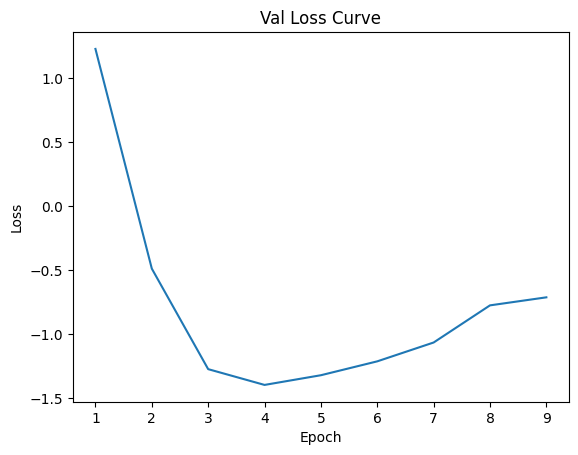

Finished Training Teacher
model is loaded properly


100%|██████████████████████████████████████████████████████████████████████████████████████| 162/162 [01:08<00:00,  2.38it/s]


Teacher weights and architecture saved and exported for lambda: 10


100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 1/300*****
*****Train Loss:  8.116145 Val Loss:  5.951139*****
*****Validation Accuracy: 53.85%*****
*****Total Avg Disparity: 0.13715943953840548*****

Class Team_Sports: Recall Difference = 0.08670071174783789
Class Celebration: Recall Difference = -0.05172413793103453
Class Parade: Recall Difference = -0.024395965282664855
Class Waiter_Or_Waitress: Recall Difference = -0.21778584392014516
Class Individual_Sports: Recall Difference = -0.1247359011864132
Class Surgeons: Recall Difference = 0.025641025641025644
Class Spa: Recall Difference = -0.08163265306122448
Class Law_Enforcement: Recall Difference = 0.23553248068886934
Class Business: Recall Difference = -0.0598891730605286
Class Dresses: Recall Difference = -0.6453423120089788
Class Water_Activities: Recall Difference = 0.1729205753595997
Class Picnic: Recall Difference = -0.10714285714285715
Class Rescue: Recall Difference = -0.016975308641975308
Class Cheering: Recall Difference = -0.0016351558507920298
Class Perform

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 2/300*****
*****Train Loss:  2.833772 Val Loss:  2.202385*****
*****Validation Accuracy: 61.62%*****
*****Total Avg Disparity: 0.19455835207840808*****

Class Team_Sports: Recall Difference = 0.10306062994824683
Class Celebration: Recall Difference = -0.0006982490063379698
Class Parade: Recall Difference = -0.00023457658925640779
Class Waiter_Or_Waitress: Recall Difference = -0.09509981851179672
Class Individual_Sports: Recall Difference = -0.17085161709735097
Class Surgeons: Recall Difference = -0.06373626373626373
Class Spa: Recall Difference = 0.6326530612244898
Class Law_Enforcement: Recall Difference = 0.207420539445359
Class Business: Recall Difference = 0.013213981244671769
Class Dresses: Recall Difference = -0.7300785634118968
Class Water_Activities: Recall Difference = 0.2083593912862206
Class Picnic: Recall Difference = -0.4642857142857143
Class Rescue: Recall Difference = -0.0532407407407407
Class Cheering: Recall Difference = 0.07020950434338266
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.99it/s]


*****Epoch 3/300*****
*****Train Loss:  0.732235 Val Loss:  1.303528*****
*****Validation Accuracy: 64.79%*****
*****Total Avg Disparity: 0.16373321094910237*****

Class Team_Sports: Recall Difference = 0.10729912830882782
Class Celebration: Recall Difference = -0.052476098399398596
Class Parade: Recall Difference = 0.012549847525216928
Class Waiter_Or_Waitress: Recall Difference = -0.11324863883847547
Class Individual_Sports: Recall Difference = -0.15719973996424508
Class Surgeons: Recall Difference = -0.09597069597069596
Class Spa: Recall Difference = 0.30612244897959184
Class Law_Enforcement: Recall Difference = 0.23135367861213119
Class Business: Recall Difference = -0.03687127024722936
Class Dresses: Recall Difference = -0.7053872053872053
Class Water_Activities: Recall Difference = 0.10100062539086929
Class Picnic: Recall Difference = -0.3392857142857142
Class Rescue: Recall Difference = -0.012345679012345678
Class Cheering: Recall Difference = 0.016760347470618275
Class Performa

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 4/300*****
*****Train Loss: -0.446927 Val Loss:  0.959955*****
*****Validation Accuracy: 65.60%*****
*****Total Avg Disparity: 0.15842539239080394*****

Class Team_Sports: Recall Difference = 0.09258434154756601
Class Celebration: Recall Difference = -0.08695885702008815
Class Parade: Recall Difference = -0.029556650246305383
Class Waiter_Or_Waitress: Recall Difference = -0.1237749546279493
Class Individual_Sports: Recall Difference = -0.16069397042093303
Class Surgeons: Recall Difference = -0.12161172161172173
Class Spa: Recall Difference = 0.26530612244897966
Class Law_Enforcement: Recall Difference = 0.13574775231100433
Class Business: Recall Difference = 0.007672634271099654
Class Dresses: Recall Difference = -0.7239057239057238
Class Water_Activities: Recall Difference = 0.11319574734208881
Class Picnic: Recall Difference = -0.3392857142857142
Class Rescue: Recall Difference = 0.04012345679012347
Class Cheering: Recall Difference = -0.06908533469596312
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 5/300*****
*****Train Loss: -1.128767 Val Loss:  0.803894*****
*****Validation Accuracy: 65.63%*****
*****Total Avg Disparity: 0.15426862262265678*****

Class Team_Sports: Recall Difference = 0.09093921010841877
Class Celebration: Recall Difference = -0.06069395208937595
Class Parade: Recall Difference = -0.012315270935960632
Class Waiter_Or_Waitress: Recall Difference = -0.06823956442831236
Class Individual_Sports: Recall Difference = -0.1623598244758655
Class Surgeons: Recall Difference = -0.1186813186813187
Class Spa: Recall Difference = 0.22448979591836737
Class Law_Enforcement: Recall Difference = 0.1655058883120173
Class Business: Recall Difference = 0.0415601023017903
Class Dresses: Recall Difference = -0.7547699214365882
Class Water_Activities: Recall Difference = 0.14488221805294976
Class Picnic: Recall Difference = -0.3392857142857143
Class Rescue: Recall Difference = 0.04012345679012347
Class Cheering: Recall Difference = -0.031067961165048563
Class Performance_An

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 6/300*****
*****Train Loss: -1.756179 Val Loss:  0.887863*****
*****Validation Accuracy: 64.88%*****
*****Total Avg Disparity: 0.17454976531676358*****

Class Team_Sports: Recall Difference = 0.0812626383795454
Class Celebration: Recall Difference = -0.03808142657643154
Class Parade: Recall Difference = 0.04058174994135588
Class Waiter_Or_Waitress: Recall Difference = -0.12087114337568072
Class Individual_Sports: Recall Difference = -0.13838777831951898
Class Surgeons: Recall Difference = -0.15018315018315032
Class Spa: Recall Difference = 0.26530612244897966
Class Law_Enforcement: Recall Difference = 0.17095099404837288
Class Business: Recall Difference = 0.03388746803069054
Class Dresses: Recall Difference = -0.6806958473625139
Class Water_Activities: Recall Difference = 0.1534292265999585
Class Picnic: Recall Difference = -0.5892857142857143
Class Rescue: Recall Difference = 0.02314814814814814
Class Cheering: Recall Difference = -0.08124680633622894
Class Performance_And

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 7/300*****
*****Train Loss: -2.124312 Val Loss:  0.888982*****
*****Validation Accuracy: 64.91%*****
*****Total Avg Disparity: 0.16094115400055983*****

Class Team_Sports: Recall Difference = 0.10565399686968047
Class Celebration: Recall Difference = -0.06321839080459768
Class Parade: Recall Difference = 0.02850105559465177
Class Waiter_Or_Waitress: Recall Difference = -0.08929219600725957
Class Individual_Sports: Recall Difference = -0.1452949780594831
Class Surgeons: Recall Difference = -0.09010989010989012
Class Spa: Recall Difference = 0.2857142857142858
Class Law_Enforcement: Recall Difference = 0.14790426744333285
Class Business: Recall Difference = 0.005541346973572003
Class Dresses: Recall Difference = -0.6992143658810325
Class Water_Activities: Recall Difference = 0.10954763393787792
Class Picnic: Recall Difference = -0.5714285714285715
Class Rescue: Recall Difference = 0.02391975308641975
Class Cheering: Recall Difference = -0.0027593254982115623
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 8/300*****
*****Train Loss: -2.394066 Val Loss:  0.930838*****
*****Validation Accuracy: 64.91%*****
*****Total Avg Disparity: 0.16748893859338246*****

Class Team_Sports: Recall Difference = 0.06859284139333488
Class Celebration: Recall Difference = -0.061445912557739846
Class Parade: Recall Difference = 0.03741496598639471
Class Waiter_Or_Waitress: Recall Difference = -0.08929219600725968
Class Individual_Sports: Recall Difference = -0.14704209328782714
Class Surgeons: Recall Difference = -0.14432234432234436
Class Spa: Recall Difference = 0.26530612244897955
Class Law_Enforcement: Recall Difference = 0.11979232619982283
Class Business: Recall Difference = 0.043691389599318065
Class Dresses: Recall Difference = -0.6498316498316498
Class Water_Activities: Recall Difference = 0.1534292265999585
Class Picnic: Recall Difference = -0.6071428571428571
Class Rescue: Recall Difference = 0.0524691358024692
Class Cheering: Recall Difference = -0.020541645375574902
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 9/300*****
*****Train Loss: -2.553827 Val Loss:  1.087625*****
*****Validation Accuracy: 65.28%*****
*****Total Avg Disparity: 0.1577417071509487*****

Class Team_Sports: Recall Difference = 0.08535261792964777
Class Celebration: Recall Difference = -0.03593296809539159
Class Parade: Recall Difference = 0.03870513722730473
Class Waiter_Or_Waitress: Recall Difference = -0.1237749546279493
Class Individual_Sports: Recall Difference = -0.12839265398992372
Class Surgeons: Recall Difference = -0.001465201465201571
Class Spa: Recall Difference = 0.2857142857142857
Class Law_Enforcement: Recall Difference = 0.09421299227554769
Class Business: Recall Difference = 0.010017050298380292
Class Dresses: Recall Difference = -0.6683501683501685
Class Water_Activities: Recall Difference = 0.1497811131957475
Class Picnic: Recall Difference = -0.6249999999999999
Class Rescue: Recall Difference = 0.05787037037037035
Class Cheering: Recall Difference = -0.021359223300970842
Class Performance_An

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 10/300*****
*****Train Loss: -2.711892 Val Loss:  1.013850*****
*****Validation Accuracy: 65.08%*****
*****Total Avg Disparity: 0.16259268250470152*****

Class Team_Sports: Recall Difference = 0.07048931235790745
Class Celebration: Recall Difference = -0.11891717692555598
Class Parade: Recall Difference = 0.022753929157870112
Class Waiter_Or_Waitress: Recall Difference = -0.07876588021778597
Class Individual_Sports: Recall Difference = -0.1623598244758655
Class Surgeons: Recall Difference = 0.02124542124542106
Class Spa: Recall Difference = 0.26530612244897966
Class Law_Enforcement: Recall Difference = 0.07534506774724581
Class Business: Recall Difference = 0.08503836317135538
Class Dresses: Recall Difference = -0.6868686868686869
Class Water_Activities: Recall Difference = 0.15217844486137178
Class Picnic: Recall Difference = -0.6071428571428571
Class Rescue: Recall Difference = 0.014660493827160503
Class Cheering: Recall Difference = 0.007766990291262099
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 11/300*****
*****Train Loss: -2.790962 Val Loss:  1.121312*****
*****Validation Accuracy: 65.11%*****
*****Total Avg Disparity: 0.15685210284008963*****

Class Team_Sports: Recall Difference = 0.08644937222241256
Class Celebration: Recall Difference = -0.0887313352669461
Class Parade: Recall Difference = 0.009383063570255645
Class Waiter_Or_Waitress: Recall Difference = -0.06061705989110722
Class Individual_Sports: Recall Difference = -0.15561514708272373
Class Surgeons: Recall Difference = -0.06153846153846154
Class Spa: Recall Difference = 0.2857142857142857
Class Law_Enforcement: Recall Difference = 0.07116626567050777
Class Business: Recall Difference = 0.03069053708439906
Class Dresses: Recall Difference = -0.5589225589225589
Class Water_Activities: Recall Difference = 0.1155930790077132
Class Picnic: Recall Difference = -0.5892857142857142
Class Rescue: Recall Difference = 0.07716049382716056
Class Cheering: Recall Difference = -0.02943280531425646
Class Performance_An

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 12/300*****
*****Train Loss: -2.839905 Val Loss:  1.206191*****
*****Validation Accuracy: 65.60%*****
*****Total Avg Disparity: 0.15496895199498578*****

Class Team_Sports: Recall Difference = 0.0869977493687949
Class Celebration: Recall Difference = -0.0955526909442474
Class Parade: Recall Difference = -0.02509969505043408
Class Waiter_Or_Waitress: Recall Difference = -0.05480943738656996
Class Individual_Sports: Recall Difference = -0.08585242970908491
Class Surgeons: Recall Difference = -0.01611721611721606
Class Spa: Recall Difference = 0.2857142857142857
Class Law_Enforcement: Recall Difference = 0.05900975053817914
Class Business: Recall Difference = 0.026214833759590994
Class Dresses: Recall Difference = -0.6083052749719415
Class Water_Activities: Recall Difference = 0.13633520950594125
Class Picnic: Recall Difference = -0.5892857142857142
Class Rescue: Recall Difference = 0.07716049382716045
Class Cheering: Recall Difference = -0.037506387327542245
Class Performance_

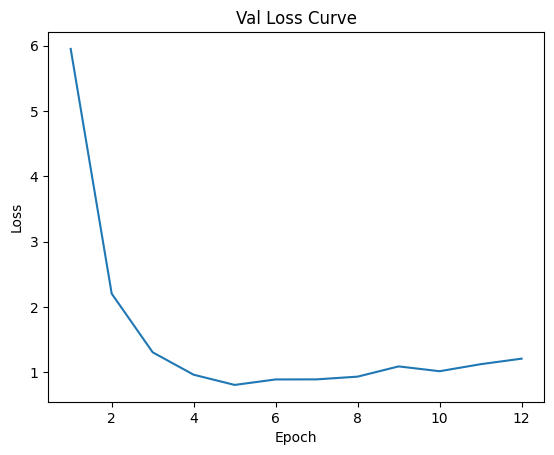

Finished Training Teacher
model is loaded properly


100%|██████████████████████████████████████████████████████████████████████████████████████| 162/162 [01:07<00:00,  2.39it/s]


Teacher weights and architecture saved and exported for lambda: 5


100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 1/300*****
*****Train Loss:  6.782962 Val Loss:  8.616423*****
*****Validation Accuracy: 54.89%*****
*****Total Avg Disparity: 0.15862799288181437*****

Class Team_Sports: Recall Difference = 0.11927202933817727
Class Celebration: Recall Difference = -0.07218820496293904
Class Parade: Recall Difference = -0.0014074595355383357
Class Waiter_Or_Waitress: Recall Difference = -0.15063520871143365
Class Individual_Sports: Recall Difference = -0.12298878595806928
Class Surgeons: Recall Difference = 0.09963369963369961
Class Spa: Recall Difference = -0.1836734693877551
Class Law_Enforcement: Recall Difference = 0.3030264657464861
Class Business: Recall Difference = -0.04241261722080131
Class Dresses: Recall Difference = -0.771604938271605
Class Water_Activities: Recall Difference = 0.1497811131957475
Class Picnic: Recall Difference = -0.1785714285714286
Class Rescue: Recall Difference = 0.0038580246913580245
Class Cheering: Recall Difference = 0.030659172202350524
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.96it/s]


*****Epoch 2/300*****
*****Train Loss:  3.485911 Val Loss:  6.118249*****
*****Validation Accuracy: 62.86%*****
*****Total Avg Disparity: 0.18738124855540061*****

Class Team_Sports: Recall Difference = 0.08739760770469895
Class Celebration: Recall Difference = -0.06461488881727373
Class Parade: Recall Difference = 0.018883415435139494
Class Waiter_Or_Waitress: Recall Difference = -0.1477313974591653
Class Individual_Sports: Recall Difference = -0.17942467089224767
Class Surgeons: Recall Difference = 0.07545787545787541
Class Spa: Recall Difference = 0.44897959183673464
Class Law_Enforcement: Recall Difference = 0.2598455109535267
Class Business: Recall Difference = 0.037084398976982125
Class Dresses: Recall Difference = -0.7839506172839508
Class Water_Activities: Recall Difference = 0.12174275588909744
Class Picnic: Recall Difference = -0.3928571428571428
Class Rescue: Recall Difference = 0.017746913580246937
Class Cheering: Recall Difference = -0.009913132345426706
Class Performance_

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 3/300*****
*****Train Loss:  2.167794 Val Loss:  5.829748*****
*****Validation Accuracy: 64.56%*****
*****Total Avg Disparity: 0.1799250924557559*****

Class Team_Sports: Recall Difference = 0.08834584318698524
Class Celebration: Recall Difference = -0.06359437103877968
Class Parade: Recall Difference = 0.04632887637813754
Class Waiter_Or_Waitress: Recall Difference = -0.09219600725952803
Class Individual_Sports: Recall Difference = -0.13164310092637732
Class Surgeons: Recall Difference = -0.06739926739926738
Class Spa: Recall Difference = 0.2857142857142857
Class Law_Enforcement: Recall Difference = 0.16677219197163473
Class Business: Recall Difference = 0.01321398124467188
Class Dresses: Recall Difference = -0.771604938271605
Class Water_Activities: Recall Difference = 0.13883677298311448
Class Picnic: Recall Difference = -0.6249999999999999
Class Rescue: Recall Difference = 0.054012345679012363
Class Cheering: Recall Difference = -0.03914154317833424
Class Performance_And

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 4/300*****
*****Train Loss:  1.209297 Val Loss:  5.649230*****
*****Validation Accuracy: 65.60%*****
*****Total Avg Disparity: 0.17559722704797742*****

Class Team_Sports: Recall Difference = 0.08889422033336758
Class Celebration: Recall Difference = -0.0865828767859061
Class Parade: Recall Difference = 0.06040347173352101
Class Waiter_Or_Waitress: Recall Difference = -0.05771324863883853
Class Individual_Sports: Recall Difference = -0.11482203803022906
Class Surgeons: Recall Difference = -0.17289377289377295
Class Spa: Recall Difference = 0.26530612244897966
Class Law_Enforcement: Recall Difference = 0.12359123717867548
Class Business: Recall Difference = 0.04475703324808189
Class Dresses: Recall Difference = -0.6992143658810325
Class Water_Activities: Recall Difference = 0.12174275588909744
Class Picnic: Recall Difference = -0.6249999999999999
Class Rescue: Recall Difference = 0.01620370370370361
Class Cheering: Recall Difference = -0.04885028104241185
Class Performance_An

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 5/300*****
*****Train Loss:  0.433494 Val Loss:  6.050241*****
*****Validation Accuracy: 65.77%*****
*****Total Avg Disparity: 0.16906158286245168*****

Class Team_Sports: Recall Difference = 0.09393243536575624
Class Celebration: Recall Difference = -0.05210011816521637
Class Parade: Recall Difference = 0.025920713112831395
Class Waiter_Or_Waitress: Recall Difference = -0.012704174228675202
Class Individual_Sports: Recall Difference = -0.08926539899236141
Class Surgeons: Recall Difference = -0.1501831501831502
Class Spa: Recall Difference = 0.30612244897959184
Class Law_Enforcement: Recall Difference = 0.12777003925541341
Class Business: Recall Difference = 0.01662404092071612
Class Dresses: Recall Difference = -0.7530864197530864
Class Water_Activities: Recall Difference = 0.1583281217427558
Class Picnic: Recall Difference = -0.6071428571428572
Class Rescue: Recall Difference = -0.009259259259259245
Class Cheering: Recall Difference = -0.030250383239652567
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 6/300*****
*****Train Loss: -0.070664 Val Loss:  6.480259*****
*****Validation Accuracy: 65.34%*****
*****Total Avg Disparity: 0.17156804336725046*****

Class Team_Sports: Recall Difference = 0.08520409911916915
Class Celebration: Recall Difference = -0.10060156837469114
Class Parade: Recall Difference = 0.025920713112831395
Class Waiter_Or_Waitress: Recall Difference = -0.07876588021778586
Class Individual_Sports: Recall Difference = -0.10791483829026494
Class Surgeons: Recall Difference = -0.09890109890109888
Class Spa: Recall Difference = 0.30612244897959184
Class Law_Enforcement: Recall Difference = 0.08585538812207172
Class Business: Recall Difference = 0.03069053708439895
Class Dresses: Recall Difference = -0.7716049382716051
Class Water_Activities: Recall Difference = 0.13883677298311436
Class Picnic: Recall Difference = -0.6071428571428572
Class Rescue: Recall Difference = -0.009259259259259356
Class Cheering: Recall Difference = -0.03270311701584061
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.96it/s]


*****Epoch 7/300*****
*****Train Loss: -0.409331 Val Loss:  6.810941*****
*****Validation Accuracy: 65.74%*****
*****Total Avg Disparity: 0.17256744887325773*****

Class Team_Sports: Recall Difference = 0.07063783116838596
Class Celebration: Recall Difference = -0.10527446557095282
Class Parade: Recall Difference = 0.043162092423176146
Class Waiter_Or_Waitress: Recall Difference = -0.09219600725952826
Class Individual_Sports: Recall Difference = -0.10283601495205597
Class Surgeons: Recall Difference = -0.15311355311355312
Class Spa: Recall Difference = 0.26530612244897966
Class Law_Enforcement: Recall Difference = 0.07914397872609868
Class Business: Recall Difference = 0.01982097186700771
Class Dresses: Recall Difference = -0.7592592592592593
Class Water_Activities: Recall Difference = 0.12049197415051072
Class Picnic: Recall Difference = -0.625
Class Rescue: Recall Difference = -0.026234567901234518
Class Cheering: Recall Difference = -0.06663260091977524
Class Performance_And_Enterta

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.97it/s]


*****Epoch 8/300*****
*****Train Loss: -0.641041 Val Loss:  6.746652*****
*****Validation Accuracy: 64.88%*****
*****Total Avg Disparity: 0.15896704702224315*****

Class Team_Sports: Recall Difference = 0.09079069129794037
Class Celebration: Recall Difference = -0.0563970351272961
Class Parade: Recall Difference = 0.04632887637813743
Class Waiter_Or_Waitress: Recall Difference = -0.07876588021778597
Class Individual_Sports: Recall Difference = -0.03823338209003735
Class Surgeons: Recall Difference = -0.2300366300366301
Class Spa: Recall Difference = 0.26530612244897966
Class Law_Enforcement: Recall Difference = 0.0887678865391921
Class Business: Recall Difference = -0.027067348678601943
Class Dresses: Recall Difference = -0.7115600448933783
Class Water_Activities: Recall Difference = 0.1046487387950803
Class Picnic: Recall Difference = -0.6249999999999999
Class Rescue: Recall Difference = -0.030864197530864168
Class Cheering: Recall Difference = -0.03106796116504862
Class Performance_A

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 9/300*****
*****Train Loss: -0.771160 Val Loss:  7.634789*****
*****Validation Accuracy: 64.96%*****
*****Total Avg Disparity: 0.1642565782964544*****

Class Team_Sports: Recall Difference = 0.04420148290320003
Class Celebration: Recall Difference = -0.06106993232355784
Class Parade: Recall Difference = 0.078935022284776
Class Waiter_Or_Waitress: Recall Difference = -0.10562613430127044
Class Individual_Sports: Recall Difference = -0.04664391353811137
Class Surgeons: Recall Difference = -0.12454212454212465
Class Spa: Recall Difference = 0.30612244897959195
Class Law_Enforcement: Recall Difference = 0.06445485627453473
Class Business: Recall Difference = 0.01982097186700771
Class Dresses: Recall Difference = -0.7469135802469137
Class Water_Activities: Recall Difference = 0.1046487387950803
Class Picnic: Recall Difference = -0.6249999999999999
Class Rescue: Recall Difference = -0.0054012345679012586
Class Cheering: Recall Difference = -0.1314256515074093
Class Performance_And

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.99it/s]


*****Epoch 10/300*****
*****Train Loss: -0.849056 Val Loss:  8.012077*****
*****Validation Accuracy: 64.56%*****
*****Total Avg Disparity: 0.165421748439537*****

Class Team_Sports: Recall Difference = 0.07826941312220814
Class Celebration: Recall Difference = -0.1350843269953808
Class Parade: Recall Difference = 0.07447806708890448
Class Waiter_Or_Waitress: Recall Difference = -0.11905626134301273
Class Individual_Sports: Recall Difference = -0.08910287664553884
Class Surgeons: Recall Difference = -0.12454212454212454
Class Spa: Recall Difference = 0.24489795918367352
Class Law_Enforcement: Recall Difference = 0.055210839559326375
Class Business: Recall Difference = -0.029198635976129594
Class Dresses: Recall Difference = -0.7222222222222222
Class Water_Activities: Recall Difference = 0.10100062539086929
Class Picnic: Recall Difference = -0.6607142857142856
Class Rescue: Recall Difference = 0.00694444444444442
Class Cheering: Recall Difference = -0.041594276954522225
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 11/300*****
*****Train Loss: -0.904807 Val Loss:  8.019590*****
*****Validation Accuracy: 64.91%*****
*****Total Avg Disparity: 0.16715931681445168*****

Class Team_Sports: Recall Difference = 0.10635089282654153
Class Celebration: Recall Difference = -0.0959286711784294
Class Parade: Recall Difference = 0.06427398545625129
Class Waiter_Or_Waitress: Recall Difference = -0.03666061705989121
Class Individual_Sports: Recall Difference = -0.061961644726149734
Class Surgeons: Recall Difference = -0.17582417582417587
Class Spa: Recall Difference = 0.326530612244898
Class Law_Enforcement: Recall Difference = 0.05900975053817903
Class Business: Recall Difference = 0.03282182438192671
Class Dresses: Recall Difference = -0.7407407407407407
Class Water_Activities: Recall Difference = 0.09735251198665829
Class Picnic: Recall Difference = -0.6607142857142858
Class Rescue: Recall Difference = -0.04243827160493835
Class Cheering: Recall Difference = -0.028615227388860576
Class Performance_

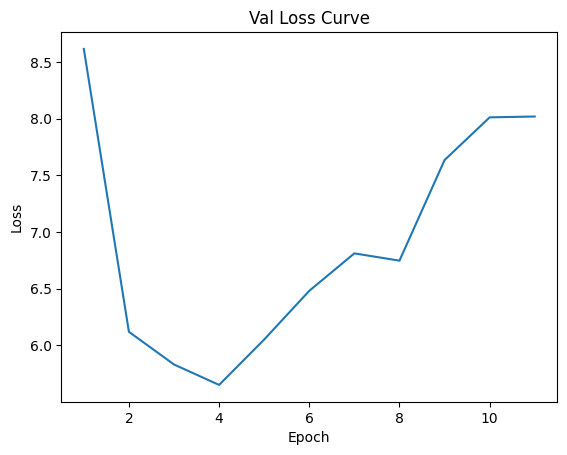

Finished Training Teacher
model is loaded properly


100%|██████████████████████████████████████████████████████████████████████████████████████| 162/162 [01:07<00:00,  2.41it/s]


Teacher weights and architecture saved and exported for lambda: 3


100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 1/300*****
*****Train Loss:  2.093331 Val Loss:  1.571533*****
*****Validation Accuracy: 55.01%*****
*****Total Avg Disparity: 0.147243008207756*****

Class Team_Sports: Recall Difference = 0.09502918965852103
Class Celebration: Recall Difference = -0.10414652486840698
Class Parade: Recall Difference = -0.007271874266948197
Class Waiter_Or_Waitress: Recall Difference = -0.17568058076225052
Class Individual_Sports: Recall Difference = -0.13148057857955464
Class Surgeons: Recall Difference = 0.04249084249084249
Class Spa: Recall Difference = -0.16326530612244897
Class Law_Enforcement: Recall Difference = 0.3193617829555526
Class Business: Recall Difference = -0.029411764705882304
Class Dresses: Recall Difference = -0.6144781144781144
Class Water_Activities: Recall Difference = 0.1656243485511779
Class Picnic: Recall Difference = -0.1785714285714286
Class Rescue: Recall Difference = -0.029320987654320986
Class Cheering: Recall Difference = 0.021768012263668854
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 2/300*****
*****Train Loss:  1.313434 Val Loss:  1.248845*****
*****Validation Accuracy: 62.91%*****
*****Total Avg Disparity: 0.16467817666938492*****

Class Team_Sports: Recall Difference = 0.08480424078326543
Class Celebration: Recall Difference = -0.03732946610806759
Class Parade: Recall Difference = 0.050785831574008844
Class Waiter_Or_Waitress: Recall Difference = -0.09219600725952826
Class Individual_Sports: Recall Difference = -0.15561514708272373
Class Surgeons: Recall Difference = 0.038827838827838856
Class Spa: Recall Difference = 0.4897959183673469
Class Law_Enforcement: Recall Difference = 0.23553248068886923
Class Business: Recall Difference = 0.0002131287297527651
Class Dresses: Recall Difference = -0.7592592592592594
Class Water_Activities: Recall Difference = 0.13393787784031697
Class Picnic: Recall Difference = -0.2678571428571429
Class Rescue: Recall Difference = 0.0015432098765432445
Class Cheering: Recall Difference = 0.060500766479304996
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.99it/s]


*****Epoch 3/300*****
*****Train Loss:  0.935686 Val Loss:  1.154036*****
*****Validation Accuracy: 65.19%*****
*****Total Avg Disparity: 0.15999997546194777*****

Class Team_Sports: Recall Difference = 0.09747403776947594
Class Celebration: Recall Difference = -0.02911161241808996
Class Parade: Recall Difference = 0.028501055594651548
Class Waiter_Or_Waitress: Recall Difference = -0.18983666061705995
Class Individual_Sports: Recall Difference = -0.07386640663091182
Class Surgeons: Recall Difference = -0.06739926739926738
Class Spa: Recall Difference = 0.2857142857142857
Class Law_Enforcement: Recall Difference = 0.16132708623527914
Class Business: Recall Difference = -0.009590792838874762
Class Dresses: Recall Difference = -0.6144781144781144
Class Water_Activities: Recall Difference = 0.13028976443610596
Class Picnic: Recall Difference = -0.3571428571428572
Class Rescue: Recall Difference = 0.06944444444444448
Class Cheering: Recall Difference = -0.09095554420030666
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.94it/s]


*****Epoch 4/300*****
*****Train Loss:  0.665525 Val Loss:  1.165579*****
*****Validation Accuracy: 65.54%*****
*****Total Avg Disparity: 0.188346304830752*****

Class Team_Sports: Recall Difference = 0.09857079206224084
Class Celebration: Recall Difference = 0.06284241057041573
Class Parade: Recall Difference = 0.008092892329345625
Class Waiter_Or_Waitress: Recall Difference = -0.07876588021778608
Class Individual_Sports: Recall Difference = -0.08410531448074099
Class Surgeons: Recall Difference = -0.20146520146520153
Class Spa: Recall Difference = 0.36734693877551017
Class Law_Enforcement: Recall Difference = 0.19108522223629232
Class Business: Recall Difference = -0.03900255754475701
Class Dresses: Recall Difference = -0.6391694725028059
Class Water_Activities: Recall Difference = 0.08515739003543898
Class Picnic: Recall Difference = -0.6071428571428572
Class Rescue: Recall Difference = 0.16435185185185192
Class Cheering: Recall Difference = -0.01808891159938686
Class Performance_An

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 5/300*****
*****Train Loss:  0.448679 Val Loss:  1.195538*****
*****Validation Accuracy: 66.06%*****
*****Total Avg Disparity: 0.1744252656020419*****

Class Team_Sports: Recall Difference = 0.1265037529560955
Class Celebration: Recall Difference = 0.024062734987646328
Class Parade: Recall Difference = 0.015130190007037303
Class Waiter_Or_Waitress: Recall Difference = -0.09981851179673329
Class Individual_Sports: Recall Difference = -0.07386640663091149
Class Surgeons: Recall Difference = -0.1186813186813187
Class Spa: Recall Difference = 0.2857142857142857
Class Law_Enforcement: Recall Difference = 0.16677219197163484
Class Business: Recall Difference = -0.0824808184143222
Class Dresses: Recall Difference = -0.6391694725028059
Class Water_Activities: Recall Difference = 0.10589952053366702
Class Picnic: Recall Difference = -0.6428571428571429
Class Rescue: Recall Difference = 0.07716049382716045
Class Cheering: Recall Difference = -0.06182933060807355
Class Performance_And_

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 6/300*****
*****Train Loss:  0.309800 Val Loss:  1.309082*****
*****Validation Accuracy: 65.51%*****
*****Total Avg Disparity: 0.16090798591554578*****

Class Team_Sports: Recall Difference = 0.09637728347671104
Class Celebration: Recall Difference = -0.024062734987646328
Class Parade: Recall Difference = 0.025334271639690487
Class Waiter_Or_Waitress: Recall Difference = -0.16588021778584383
Class Individual_Sports: Recall Difference = -0.08243946042580841
Class Surgeons: Recall Difference = -0.09304029304029315
Class Spa: Recall Difference = 0.34693877551020413
Class Law_Enforcement: Recall Difference = 0.19108522223629232
Class Business: Recall Difference = 0.03069053708439895
Class Dresses: Recall Difference = -0.5482603815937149
Class Water_Activities: Recall Difference = 0.08025849489264136
Class Picnic: Recall Difference = -0.6071428571428572
Class Rescue: Recall Difference = -0.0007716049382716084
Class Cheering: Recall Difference = -0.03515585079202865
Class Performa

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 7/300*****
*****Train Loss:  0.209924 Val Loss:  1.351125*****
*****Validation Accuracy: 65.11%*****
*****Total Avg Disparity: 0.16441574171538476*****

Class Team_Sports: Recall Difference = 0.09692566062309349
Class Celebration: Recall Difference = 0.007895584917821608
Class Parade: Recall Difference = 0.07764485104386576
Class Waiter_Or_Waitress: Recall Difference = -0.11324863883847558
Class Individual_Sports: Recall Difference = -0.07561352185925552
Class Surgeons: Recall Difference = -0.12161172161172173
Class Spa: Recall Difference = 0.36734693877551017
Class Law_Enforcement: Recall Difference = 0.17095099404837277
Class Business: Recall Difference = -0.018329070758738464
Class Dresses: Recall Difference = -0.5235690235690236
Class Water_Activities: Recall Difference = 0.05586825099020243
Class Picnic: Recall Difference = -0.6428571428571429
Class Rescue: Recall Difference = 0.06095679012345678
Class Cheering: Recall Difference = -0.07235564639754727
Class Performance

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.96it/s]


*****Epoch 8/300*****
*****Train Loss:  0.152271 Val Loss:  1.400558*****
*****Validation Accuracy: 65.40%*****
*****Total Avg Disparity: 0.15267132936358538*****

Class Team_Sports: Recall Difference = 0.08221087386183179
Class Celebration: Recall Difference = 0.005747126436781547
Class Parade: Recall Difference = 0.01196340605207602
Class Waiter_Or_Waitress: Recall Difference = -0.13720508166969148
Class Individual_Sports: Recall Difference = -0.060377051844628604
Class Surgeons: Recall Difference = -0.14432234432234436
Class Spa: Recall Difference = 0.2857142857142857
Class Law_Enforcement: Recall Difference = 0.1466379637837153
Class Business: Recall Difference = -0.019394714407502067
Class Dresses: Recall Difference = -0.5173961840628508
Class Water_Activities: Recall Difference = 0.06316447779862422
Class Picnic: Recall Difference = -0.6785714285714285
Class Rescue: Recall Difference = 0.014660493827160503
Class Cheering: Recall Difference = -0.019724067450178906
Class Performanc

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 9/300*****
*****Train Loss:  0.121392 Val Loss:  1.471518*****
*****Validation Accuracy: 64.73%*****
*****Total Avg Disparity: 0.14714166634825032*****

Class Team_Sports: Recall Difference = 0.09882213158766617
Class Celebration: Recall Difference = -0.005747126436781602
Class Parade: Recall Difference = 0.017006802721088454
Class Waiter_Or_Waitress: Recall Difference = -0.012704174228675202
Class Individual_Sports: Recall Difference = -0.07727937591418821
Class Surgeons: Recall Difference = -0.14432234432234436
Class Spa: Recall Difference = 0.2857142857142857
Class Law_Enforcement: Recall Difference = 0.19779663163226546
Class Business: Recall Difference = 0.02408354646206312
Class Dresses: Recall Difference = -0.5235690235690237
Class Water_Activities: Recall Difference = 0.08150927663122798
Class Picnic: Recall Difference = -0.5892857142857143
Class Rescue: Recall Difference = -0.03858024691358025
Class Cheering: Recall Difference = -0.042411854879918276
Class Performan

100%|████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 10/300*****
*****Train Loss:  0.091898 Val Loss:  1.502901*****
*****Validation Accuracy: 65.17%*****
*****Total Avg Disparity: 0.14880386857002906*****

Class Team_Sports: Recall Difference = 0.09951902754452713
Class Celebration: Recall Difference = -0.026963153937050177
Class Parade: Recall Difference = 0.03237156931738194
Class Waiter_Or_Waitress: Recall Difference = -0.04428312159709635
Class Individual_Sports: Recall Difference = -0.0806923451974646
Class Surgeons: Recall Difference = -0.0871794871794872
Class Spa: Recall Difference = 0.36734693877551017
Class Law_Enforcement: Recall Difference = 0.17892870710396358
Class Business: Recall Difference = 0.0012787723785165905
Class Dresses: Recall Difference = -0.511223344556678
Class Water_Activities: Recall Difference = 0.09370439858244739
Class Picnic: Recall Difference = -0.6071428571428572
Class Rescue: Recall Difference = 0.00694444444444442
Class Cheering: Recall Difference = -0.050485436893203894
Class Performance

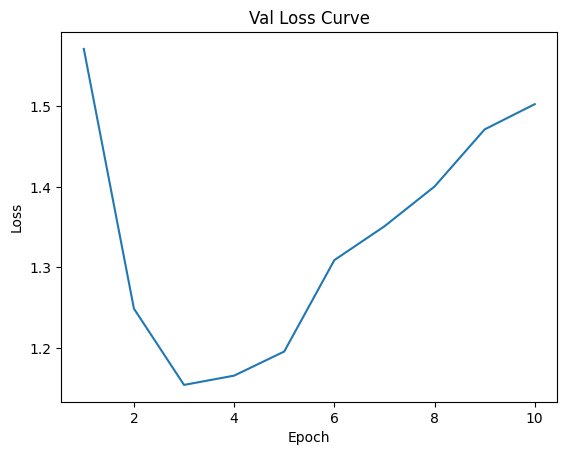

Finished Training Teacher
model is loaded properly


100%|██████████████████████████████████████████████████████████████████████████████████████| 162/162 [01:07<00:00,  2.40it/s]


Teacher weights and architecture saved and exported for lambda: 0


In [80]:
# Initialize the dictionary for results
lambda_results = {}

# Loop for training the teacher model with different lambda values
for i in lmda_list_teacher:
    # Reset the teacher model for each lambda
    teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')    
    # Replace the last fully connected layer with a new one
    teacher_model.classifier = nn.Linear(1536, num_classes)
    teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=best_lr_teacher)

    teacher_model_weights_path = f'weights/teacher_model_weights_{model_name}_{data_name}_{i}.pth'
    
    # Initialize the adversary for the teacher
    adv = Adversary()
    teacher_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_teacher)

    # pretrain_teacher(teacher_model, trainloader, criterion_clf, teacher_optimizer, device, epochs_pretrain)
    # pretrain_adversary(adv, student_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    # lmda = i

    # Train the teacher model with adversarial training
    teacher_mean_abs_val_disparity = train_teacher(model_name, data_name, teacher_model, adv, trainloader, criterion_clf, adv_criterion, teacher_optimizer, teacher_optimizer_adv, device, epochs, i, patience=patience_teacher)

    # extract class mean embeddings for teacher
    retrieve_teacher_class_weights(model_name, teacher_model, teacher_model_weights_path, num_classes, data_name, testloader, batch_size, bucket_name, i)

    # Save the teacher model and its state
    # torch.save(teacher_model.state_dict(), f'teacher_model_weights_ckd_wider_lambda{i}.pth')
    # torch.save(teacher_model, f'teacher_model_ckd_wider_lambda{i}.pth')
    print('Teacher weights and architecture saved and exported for lambda:', i)

    # Store the teacher results in the dictionary
    lambda_results[i] = {
        'teacher_mean_abs_val_disparity': teacher_mean_abs_val_disparity
    }


## KD training

In [57]:
## Training script

def train(student, teacher, T_EMB, train_dataloader, optimizer, criterion, kd_loss, nd_loss, epoch, batch_size, temperature, adv, adv_criterion, optimizer_adv, lmda):

    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()
        return hook
    
    train_loss = AverageMeter()
    train_error = AverageMeter()

    Cls_loss = AverageMeter()
    Div_loss = AverageMeter()
    Norm_Dir_loss = AverageMeter()

    # First train adversary in this epoch
    train_adversary(adv, student, optimizer_adv, train_dataloader, adv_criterion, 1)

    # test T_EMB
    T_EMB = T_EMB

    # Model on train mode
    student.train()
    teacher.eval()
    running_loss = 0.0 
    epoch_loss = 0.0  
    num_batches = 0 
    confusion_male = np.zeros((num_classes, num_classes))
    confusion_female = np.zeros((num_classes, num_classes))
 
    step_per_epoch = len(train_dataloader)

    for step, data in enumerate(tqdm(train_dataloader)):
        
        start = time.time()
        s_FEATS = []
        features = {}

        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)

        curr_batch_size = len(inputs)

        # register hook for feature embeddings
        student.avgpool.register_forward_hook(get_features('feats'))
        
        # compute output
        optimizer.zero_grad()
        s_logits = student(inputs)

        s_FEATS.append(features['feats'].cpu().numpy())
        s_emb = np.concatenate(s_FEATS)
        # print(f'before reshaping s_emb: {s_emb.shape}')
        # reshape embedding features to flatten 
        s_emb = s_emb.reshape((curr_batch_size, s_emb.shape[1]))
        s_emb = torch.from_numpy(s_emb)
        s_emb = s_emb.to(device)

        # fix embedding output on student model
        s_emb_size = 1280
        t_emb_size = 1536
        
        emb_inflate = nn.Sequential(
            nn.BatchNorm1d(s_emb_size),
            nn.Dropout(0.5),
            nn.Linear(s_emb_size, t_emb_size)
            )
        
        ## clean model
        for m in student.modules():
            if isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

        
        emb_inflate.to(device)

        s_emb = emb_inflate(s_emb)
        
        with torch.no_grad():
                        
            ####
            
            t_FEATS = []
            features = {}
    
            # register hook for feature embeddings
            teacher.avgpool.register_forward_hook(get_features('feats'))
            
            # compute output
            t_logits = teacher(inputs)
    
            t_FEATS.append(features['feats'].cpu().numpy())
            t_emb = np.concatenate(t_FEATS)
            # reshape embedding features to flatten 
            t_emb = t_emb.reshape((curr_batch_size, t_emb.shape[1]))


        ## save s_emb and t_emb as torch tensors 
        t_emb = torch.from_numpy(t_emb)

        # s_emb = s_emb.to(device)
        t_emb = t_emb.to(device)


        # print(s_emb.size() == s_emb.size())
        # print(s_emb.size())
        # print(s_emb.size())
        
        ###

        # detach student_outputs to avoid exploding gradients by passing same inputs (with gradience) into two different models. 
        studentached = s_logits.detach()
        # One-hot encode labels and concatenate with student's predictions
        one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
        concatenated_output = torch.cat((studentached, one_hot_labels), dim=1)

        # Run the adversarial model on concatenated true labels, and predicted labels
        with torch.no_grad():
            adversary_output = adv(concatenated_output)

        
         # Calc adversary loss, which is an MSE loss, because this is a regression output.       
        adversary_loss = adv_criterion(adversary_output, targets)
        # cls loss
        cls_loss = criterion(s_logits, labels) * cls_loss_factor
        # KD loss
        div_loss = kd_loss(s_out = s_logits, t_out = t_logits) * min(1.0, epoch/warm_up)
        # ND loss
        norm_dir_loss = nd_loss(s_emb=s_emb, t_emb=t_emb, T_EMB=T_EMB, labels=labels)

        if lmda != 0:
            loss = cls_loss + div_loss + norm_dir_loss + (cls_loss + div_loss + norm_dir_loss)/adversary_loss - lmda * adversary_loss
        else:
            loss = cls_loss + div_loss + norm_dir_loss
        
        # measure accuracy and record loss
        batch_size = inputs.size(0)
        _, pred = s_logits.data.cpu().topk(1, dim=1)
        train_error.update(torch.ne(pred.squeeze(), labels.cpu()).float().sum().item() / batch_size, batch_size)
        train_loss.update(loss.item(), batch_size)

        Cls_loss.update(cls_loss.item(), batch_size)
        Div_loss.update(div_loss.item(), batch_size)
        Norm_Dir_loss.update(norm_dir_loss.item(), batch_size)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()
        num_batches += 1

        t = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
        s1 = '\r{} [{}/{}]'.format(t, step+1, step_per_epoch)
        s2 = ' - {:.2f}ms/step - nd_loss: {:.3f} - kd_loss: {:.3f} - cls_loss: {:.3f} - train_loss: {:.3f} - train_acc: {:.3f}'.format(
             1000 * (time.time() - start), norm_dir_loss.item(), div_loss.item(), cls_loss.item(), train_loss.val, 1-train_error.val)

        print(s1+s2, end='', flush=True)

    epoch_loss /= num_batches
    # student_epoch_losses.append(epoch_loss)


    print()
    return Norm_Dir_loss.avg, Div_loss.avg, Cls_loss.avg, train_loss.avg, train_error.avg


def test(student, teacher, test_dataloader, criterion, adv, lmda, kd_loss, nd_loss, epoch, optimizer):

    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()
        return hook
    
    test_loss = AverageMeter()
    test_error = AverageMeter()

    # Model on eval mode
    student.eval()
    teacher.eval()
    total_correct = 0
    total_samples = 0
    total_val_loss = 0.0
    num_batches = 0


    with torch.no_grad():
        for step, data in enumerate(tqdm(test_dataloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)

            # compute logits
            s_logits = student(inputs)
            t_logits = teacher(inputs)

            # get feature embeddings

            #########

            curr_batch_size = len(inputs)

            # register hook for feature embeddings
            student.avgpool.register_forward_hook(get_features('feats'))
            
            # compute output
            optimizer.zero_grad()
            s_logits = student(inputs)
    
            s_FEATS.append(features['feats'].cpu().numpy())
            s_emb = np.concatenate(s_FEATS)
            # print(f'before reshaping s_emb: {s_emb.shape}')
            # reshape embedding features to flatten 
            s_emb = s_emb.reshape((curr_batch_size, s_emb.shape[1]))
            s_emb = torch.from_numpy(s_emb)
            s_emb = s_emb.to(device)
    
            # fix embedding output on student model
            s_emb_size = 1280
            t_emb_size = 1536
            
            emb_inflate = nn.Sequential(
                nn.BatchNorm1d(s_emb_size),
                nn.Dropout(0.5),
                nn.Linear(s_emb_size, t_emb_size)
                )

            ## clean model
            for m in student.modules():
                if isinstance(m, nn.BatchNorm1d):
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()
                elif isinstance(m, nn.Linear):
                    m.bias.data.zero_()
    
            
            emb_inflate.to(device)
    
            s_emb = emb_inflate(s_emb)


            t_FEATS = []
            features = {}
    
            # register hook for feature embeddings
            teacher.avgpool.register_forward_hook(get_features('feats'))
            
            # compute output
            t_logits = teacher(inputs)
    
            t_FEATS.append(features['feats'].cpu().numpy())
            t_emb = np.concatenate(t_FEATS)
            # reshape embedding features to flatten 
            t_emb = t_emb.reshape((curr_batch_size, t_emb.shape[1]))


            ## save s_emb and t_emb as torch tensors 
            t_emb = torch.from_numpy(t_emb)
    
            # s_emb = s_emb.to(device)
            t_emb = t_emb.to(device)
        
            ##########


            
            studentached = s_logits.detach()   
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((studentached, one_hot_labels), dim=1)

            adversary_output = adv(concatenated_output)
            adversary_loss = adv_criterion(adversary_output, targets)
            # cls loss
            cls_loss = criterion(s_logits, labels) * cls_loss_factor
            # KD loss
            div_loss = kd_loss(s_out = s_logits, t_out = t_logits) * min(1.0, epoch/warm_up)
            # ND loss
            norm_dir_loss = nd_loss(s_emb=s_emb, t_emb=t_emb, T_EMB=T_EMB, labels=labels)

            if lmda != 0:
                test_loss = cls_loss + div_loss + norm_dir_loss + (cls_loss + div_loss + norm_dir_loss)/adversary_loss - lmda * adversary_loss
            else:
                test_loss = cls_loss + div_loss + norm_dir_loss
            

            # measure accuracy and record loss
            batch_size = inputs.size(0)
            _, pred = s_logits.data.cpu().topk(1, dim=1)
            test_error.update(torch.ne(pred.squeeze(), labels.cpu()).float().sum().item() / batch_size, batch_size)
            test_loss.update(loss.item(), batch_size)

            
            total_val_loss += val_loss.item()

            # Compute the validation accuracy
            _, predicted = torch.max(s_logits, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            num_batches += 1
            recall_diff = evaluate_model_with_gender_multiclass(predicted, labels, targets, num_classes=num_classes)
            confusion_male += recall_diff[1]
            confusion_female += recall_diff[2]

        ##
        total_val_loss /= num_batches
        confusion_male /= num_batches
        confusion_female /= num_batches

        epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
        val_losses.append(total_val_loss)
        non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
        mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
        val_disparities.append(mean_non_zero_abs_disparity)
        accuracy = total_correct / total_samples
        val_accuracies.append(accuracy)
        print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
        f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
        f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
        f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
        class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
        
        # Print disparities by class label
        for class_label, recall_diff in class_recall_mapping.items():
            print(f"Class {class_label}: Recall Difference = {recall_diff}")


    # Check for early stopping
    if abs(total_val_loss) < abs(best_total_val_loss):
        best_total_val_loss = total_val_loss
        patience_counter = 0
        best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
        torch.save(student.state_dict(), f'weights/student_model_weights_efficientnetb0_wider_checkpoint_lmda_{lmda}.pth')
        torch.save(student, f'weights/student_model_efficientnetb0_wider_checkpoint_lmda_{lmda}.pth')
    else:
        patience_counter += 1 

    file_path = os.path.join(output_dir, f'student_validation_{lmda}.txt')
    
    # Append data to the text file
    with open(file_path, 'a') as file:
        file.write(f'********Epoch: {epochs}***********')
        
        file.write("Student Val Accuracies:\n")
        for accuracy in val_accuracies:
            file.write(f"{accuracy}\n")
    
        file.write("\nStudent Val Disparities:\n")
        for disparity in val_disparities:
            file.write(f"{disparity}\n")

        for class_label, recall_diff in class_recall_mapping.items():
            file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")

    if patience_counter >= patience:
        print('Early stopping')
        return test_loss.avg, test_error.avg
    
    print(f"Data has been appended to {file_path}")

    return test_loss.avg, test_error.avg


def epoch_loop(student, teacher, train_loader, test_loader, num_class, T_EMB, save_dir, batch_size, logger, lr, lmda):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    # student = nn.DataParallel(student, device_ids=args.gpus)
    # student = nn.DataParallel(student)
    student = student
    student.to(device)
    # teacher = nn.DataParallel(teacher, device_ids=args.gpus)
    # teacher = nn.DataParallel(teacher)
    teacher = teacher
    teacher.to(device)

    best_val_accuracy = 0
    best_total_val_loss = float('inf')
    best_epoch_accuracy = 0.0
    best_epoch_disparity = 0.0
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    val_disparities = []
    val_accuracies = []

    # loss
    criterion = nn.CrossEntropyLoss().to(device)
    kd_loss = KDLoss(kl_loss_factor=kd_loss_factor, T=t).to(device)
    nd_loss = DirectNormLoss(num_class=num_class, nd_loss_factor=nd_loss_factor).to(device)
    # optimizer
    optimizer = torch.optim.SGD(params=student.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=True)

    # weights
    save_dir = Path(save_dir)
    weights = save_dir / 'weights'
    weights.mkdir(parents=True, exist_ok=True)
    last = weights / 'last'
    best = weights / 'best'

    # acc,loss
    acc_loss = save_dir / 'acc_loss'
    acc_loss.mkdir(parents=True, exist_ok=True)

    train_acc_savepath = acc_loss / 'train_acc.npy'
    train_loss_savepath = acc_loss / 'train_loss.npy'
    val_acc_savepath = acc_loss / 'val_acc.npy'
    val_loss_savepath = acc_loss / 'val_loss.npy'

    # tensorboard
    logdir = save_dir / 'logs'
    logdir.mkdir(parents=True, exist_ok=True)
    summary_writer = SummaryWriter(logdir, flush_secs=120)


    start_epoch = 0
    best_error = 0
    train_acc = []
    train_loss = []
    test_acc = []
    test_loss = []

    logger = logger

    # Train model
    best_error = 1
    for epoch in range(start_epoch, epochs):
        if epoch in [150, 180, 210]:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1
        print("Epoch {}/{}".format(epoch + 1, epochs))
        norm_dir_loss, div_loss, cls_loss, train_epoch_loss, train_error = train(student=student,
                                                                                 teacher=teacher,
                                                                                 T_EMB=T_EMB,
                                                                                 train_dataloader=train_loader,
                                                                                 optimizer=optimizer,
                                                                                 criterion=criterion,
                                                                                 kd_loss=kd_loss,
                                                                                 nd_loss=nd_loss,
                                                                                 epoch=epoch,
                                                                                 batch_size = batch_size,
                                                                                 temperature = temperature, 
                                                                                 adv = adv, 
                                                                                 adv_criterion = adv_criterion, 
                                                                                 optimizer_adv=optimizer_adv,
                                                                                 lmda = lmda)
        test_epoch_loss, test_error = test(student=student,
                                           teacher=teacher,
                                           test_dataloader=test_loader,
                                           criterion=criterion,
                                           adv = adv,
                                           lmda = lmda,
                                           kd_loss = kd_loss,
                                           nd_loss = nd_loss,
                                           epoch=epoch,
                                           optimizer=optimizer)

        s = "Train Loss: {:.3f}, Train Acc: {:.3f}, Test Loss: {:.3f}, Test Acc: {:.3f}, lr: {:.5f}".format(
            train_epoch_loss, 1-train_error, test_epoch_loss, 1-test_error, optimizer.param_groups[0]['lr'])
        logger.info(colorstr('green', s))

        # save acc,loss
        train_loss.append(train_epoch_loss)
        train_acc.append(1-train_error)
        test_loss.append(test_epoch_loss)
        test_acc.append(1-test_error)

        # save model
        is_best = test_error < best_error
        best_error = min(best_error, test_error)
        state = {
                'epoch': epoch + 1,
                'model_state_dict': student.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_error': best_error,
                'train_acc': train_acc,
                'train_loss': train_loss,
                'test_acc': test_acc,
                'test_loss': test_loss,
            }

        last_path = last / 'epoch_{}_loss_{:.3f}_acc_{:.3f}'.format(
            epoch + 1, test_epoch_loss, 1-test_error)
        best_path = best / 'epoch_{}_acc_{:.3f}'.format(
                epoch + 1, 1-best_error)

        Save_Checkpoint(state, last, last_path, best, best_path, is_best)

        # tensorboard
        if epoch == 1:
            # images, labels = next(iter(train_loader))
            data = next(iter(train_loader))
            images = data['img'].to(device)
            labels = data['label'].to(device)

            img_grid = torchvision.utils.make_grid(images)
            summary_writer.add_image('Image', img_grid)
        summary_writer.add_scalar('lr', optimizer.param_groups[0]['lr'], epoch)
        summary_writer.add_scalar('train_loss', train_epoch_loss, epoch)
        summary_writer.add_scalar('train_error', train_error, epoch)
        summary_writer.add_scalar('val_loss', test_epoch_loss, epoch)
        summary_writer.add_scalar('val_error', test_error, epoch)

        summary_writer.add_scalar('nd_loss', norm_dir_loss, epoch)
        summary_writer.add_scalar('kd_loss', div_loss, epoch)
        summary_writer.add_scalar('cls_loss', cls_loss, epoch)

    summary_writer.close()
    import os
    if not os.path.exists(train_acc_savepath) or not os.path.exists(train_loss_savepath):
        np.save(train_acc_savepath, train_acc)
        np.save(train_loss_savepath, train_loss)
        np.save(val_acc_savepath, test_acc)
        np.save(val_loss_savepath, test_loss)

    plot_loss_curve(val_losses)

    return best_epoch_mean_abs_disparity

In [58]:
# set some params
workers = 8 # number of data loading workers
momentum = 0.9 # SGD momentum
cls_loss_factor =1.0 # cls loss weight factor
kd_loss_factor =1.0 #KD loss weight factor
t =4.0 #temperature
nd_loss_factor =1.0 # ND loss weight factor
warm_up=20.0 #loss weight warm up epochs
weight_decay = 5e-4 

def run_norm_and_dir_kd(save_dir, student_model, teacher_model, teacher_weights_path, num_class, epochs, batch_size, lr, lmda):
    
    logging.basicConfig(level=logging.INFO, format='%(asctime)s [line:%(lineno)d] %(message)s',
                        datefmt='%d %b %Y %H:%M:%S')
    logger = logging.getLogger(__name__)
    logger.info(colorstr('green', "Distribute train, total batch size:{}, epoch:{}".format(batch_size, epochs)))
 
    
    # load in models
    student = student_model
    
    teacher = teacher_model
    
    print('Load Teacher Weights')

    ###
    session = boto3.session.Session()
    s3 = session.client('s3')
    bucket_name = '210bucket' 

    teacher_model_weights_buffer = io.BytesIO()
    s3.download_fileobj(bucket_name, teacher_weights_path, teacher_model_weights_buffer)
    teacher_model_weights_buffer.seek(0)  

    # Load the model
    # model = models_package.__dict__[model_name](num_class=num_class)
    teacher_ckpt = torch.load(teacher_model_weights_buffer)
    teacher.load_state_dict(teacher_ckpt)
    # print("Keys in checkpoint:", teacher_ckpt.keys())
    print("model is loaded properly")

        
    # teacher_ckpt = torch.load(teacher_weights)['model']
    # teacher.load_state_dict(teacher_ckpt)

    for param in teacher.parameters():
        param.requires_grad = False

    ## get teacher class mean embeddings
    with open("./class_means/WIDER_embedding_fea/efficientnetb3.json", 'r') as f:
        T_EMB = json.load(f)
    f.close()

    logger.info(colorstr('green', 'Use ' + 'efficientnetb3' + ' Training ' + 'efficientnetb0' + ' ...'))


    # Train the model
    best_epoch_mean_abs_disparity = epoch_loop(student=student, teacher=teacher, train_loader = trainloader, test_loader = testloader, num_class = num_classes, T_EMB = T_EMB, save_dir = save_dir, batch_size = batch_size, logger = logger, lr = best_lr_student, lmda = lmda)

    return best_epoch_mean_abs_disparity

In [59]:
# Loop for training the student model with different lambda values
for i in lmda_list_student:
    # load teacher model with lambda 0

    teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')
    teacher_model.classifier = nn.Linear(1536, num_classes)
    teacher_model_weights_path = f'weights/teacher_model_weights_{model_name}_{data_name}_{i}.pth'

    student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
    student_model.classifier = nn.Linear(1280, num_classes)

    student_optimizer = optim.Adam(student_model.parameters(), lr=best_lr_student)
    student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)
    
    adv = Adversary()
    adv.to(device)
    student_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_student)

    
    pretrain_student(student_model, teacher_model, trainloader, criterion_clf, student_optimizer, device, alpha, temperature, epochs_pretrain)
    pretrain_adversary(adv, teacher_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    student_mean_abs_val_disparity = run_norm_and_dir_kd(save_dir, student_model, teacher_model, teacher_model_weights_path, num_classes, epochs, batch_size, best_lr_student, i)


    # torch.save(student_model.state_dict(), f'student_model_weights_ckd_wider_lambda{i}.pth')
    # torch.save(student_model, f'student_model_ckd_wider_lambda{i}.pth')
    # print('Student weights and architecture saved and exported for lambda:', i)

    # Check if the key exists in the dictionary
    if i not in lambda_results:
        # If not, create a new entry for that key
        lambda_results[i] = {
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
    }
    else:
        # If the key exists, update the existing entry
        lambda_results[i].update({
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        })


100%|██████████████████████████████████████████████████████████████████████████████████████| 162/162 [01:22<00:00,  1.97it/s]


*******Epoch 0: loss - 0.5741341257536853


100%|██████████████████████████████████████████████████████████████████████████████████████| 162/162 [01:22<00:00,  1.96it/s]


*******Epoch 1: loss - 0.26860244618153867


100%|██████████████████████████████████████████████████████████████████████████████████████| 162/162 [01:22<00:00,  1.96it/s]


*******Epoch 2: loss - 0.26330004531292267


  0%|                                                                                                | 0/162 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 46.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 35.06 MiB is free. Including non-PyTorch memory, this process has 14.71 GiB memory in use. Of the allocated memory 13.99 GiB is allocated by PyTorch, and 579.65 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }

def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

In [ ]:
# Loop through each lambda value
for lmda_teacher in lmda_list_teacher:
    for lmda_student in lmda_list_student:

    # Load teacher and student models for the current lambda
    teacher_model = torch.load(f'weights/teacher_model_weights_{model_name}_{dataset}_{lmda}.pth')
    student_model = torch.load(f'weights/student_model_weights_efficientnetb0_wider_checkpoint_lmda_{lmda}.pth')

    # Compute performance metrics
    performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)

    # Compute model sizes and inference times
    teacher_params, student_params = compare_model_size(teacher_model, student_model)
    teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)

    # Update results for the current lambda value
    if lmda in lambda_results:
        lambda_results[lmda].update({
            'performance_metrics': performance_metrics,
            'teacher_params': teacher_params,
            'student_params': student_params,
            'teacher_time': teacher_time,
            'student_time': student_time
        })
    else:
        lambda_results[lmda] = {
            'performance_metrics': performance_metrics,
            'teacher_params': teacher_params,
            'student_params': student_params,
            'teacher_time': teacher_time,
            'student_time': student_time
        }

In [ ]:
# Initialize lists to store accuracies
teacher_accuracies = []
student_accuracies = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Access the performance metrics for each pair
    teacher_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][0]
    student_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][1]

    # Append accuracies to the lists
    teacher_accuracies.append((lmda_teacher, teacher_accuracy))
    student_accuracies.append((lmda_student, student_accuracy))

# To plot, you might need to separate the lambda values and accuracies
teacher_lambdas, teacher_acc = zip(*teacher_accuracies)
student_lambdas, student_acc = zip(*student_accuracies)

# Plotting
plt.plot(teacher_lambdas, teacher_acc, label='Teacher Accuracy', marker='o')
plt.plot(student_lambdas, student_acc, label='Student Accuracy', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Initialize lists to store precisions
teacher_precisions = []
student_precisions = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the precision metrics for each pair
        teacher_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][0]
        student_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append precisions to the lists along with lambda values
    teacher_precisions.append((lmda_teacher, teacher_precision))
    student_precisions.append((lmda_student, student_precision))

# To plot, you might need to separate the lambda values and precisions
teacher_lambdas, teacher_prec = zip(*teacher_precisions)
student_lambdas, student_prec = zip(*student_precisions)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_prec, label='Teacher Precision', marker='o')
plt.plot(student_lambdas, student_prec, label='Student Precision', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Precision')
plt.title('Precision Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Initialize lists to store recalls
teacher_recalls = []
student_recalls = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the recall metrics for each pair
        teacher_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][0]
        student_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append recalls to the lists along with lambda values
    teacher_recalls.append((lmda_teacher, teacher_recall))
    student_recalls.append((lmda_student, student_recall))

# To plot, you might need to separate the lambda values and recalls
teacher_lambdas, teacher_rec = zip(*teacher_recalls)
student_lambdas, student_rec = zip(*student_recalls)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_rec, label='Teacher Recall', marker='o')
plt.plot(student_lambdas, student_rec, label='Student Recall', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Recall')
plt.title('Recall Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Initialize lists to store F1 scores
teacher_f1s = []
student_f1s = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the F1 scores for each pair
        teacher_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][0]
        student_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append F1 scores to the lists along with lambda values
    teacher_f1s.append((lmda_teacher, teacher_f1))
    student_f1s.append((lmda_student, student_f1))

# To plot, you might need to separate the lambda values and F1 scores
teacher_lambdas, teacher_f1_scores = zip(*teacher_f1s)
student_lambdas, student_f1_scores = zip(*student_f1s)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_f1_scores, label='Teacher F1 Score', marker='o')
plt.plot(student_lambdas, student_f1_scores, label='Student F1 Score', marker='o')
plt.xlabel('Lambda')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Initialize lists to store model sizes
teacher_sizes = []
student_sizes = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the model sizes for each pair
        teacher_size = lambda_results[(lmda_teacher, lmda_student)]['teacher_params'] / 1e6  # Convert to millions
        student_size = lambda_results[(lmda_teacher, lmda_student)]['student_params'] / 1e6
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append model sizes to the lists along with lambda values
    teacher_sizes.append((lmda_teacher, teacher_size))
    student_sizes.append((lmda_student, student_size))

# To plot, you might need to separate the lambda values and model sizes
teacher_lambdas, teacher_model_sizes = zip(*teacher_sizes)
student_lambdas, student_model_sizes = zip(*student_sizes)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_model_sizes, label='Teacher Model Size', marker='o')
plt.plot(student_lambdas, student_model_sizes, label='Student Model Size', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Model Size (Millions of Parameters)')
plt.title('Model Size Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Initialize lists to store inference times
teacher_times = []
student_times = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the inference times for each pair
        teacher_time = lambda_results[(lmda_teacher, lmda_student)]['teacher_time']
        student_time = lambda_results[(lmda_teacher, lmda_student)]['student_time']
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append inference times to the lists along with lambda values
    teacher_times.append((lmda_teacher, teacher_time))
    student_times.append((lmda_student, student_time))

# To plot, you might need to separate the lambda values and inference times
teacher_lambdas, teacher_inference_times = zip(*teacher_times)
student_lambdas, student_inference_times = zip(*student_times)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_inference_times, label='Teacher Inference Time', marker='o')
plt.plot(student_lambdas, student_inference_times, label='Student Inference Time', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
# Initialize lists to store disparity values
teacher_disparities = []
student_disparities = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if it's an integer key (indicating a lambda value for student)
    if isinstance(key, int):
        # Check and extract teacher disparity if it exists
        if 'teacher_mean_abs_val_disparity' in lambda_results[key]:
            teacher_disparity = lambda_results[key]['teacher_mean_abs_val_disparity']
            if isinstance(teacher_disparity, list):  # Assuming the disparity could be stored as a list
                teacher_disparity = teacher_disparity[0]
            teacher_disparities.append((key, teacher_disparity))

        # Extract student disparity
        if 'student_mean_abs_val_disparity' in lambda_results[key]:
            student_disparity = lambda_results[key]['student_mean_abs_val_disparity']
            student_disparities.append((key, student_disparity))

# Separate the lambda values and disparity values
teacher_lambdas, teacher_disparity_values = zip(*teacher_disparities) if teacher_disparities else ([], [])
student_lambdas, student_disparity_values = zip(*student_disparities) if student_disparities else ([], [])

# Plotting
plt.figure(figsize=(10, 6))
if teacher_disparities:
    plt.plot(teacher_lambdas, teacher_disparity_values, label='Teacher Average Disparity', marker='o')
if student_disparities:
    plt.plot(student_lambdas, student_disparity_values, label='Student Average Disparity', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Average Disparity')
plt.title('Average Disparity Comparison Across Lambdas')
plt.legend()
plt.show()


In [ ]:
def plot_distribution(predictions, class_names, title):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=predictions)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(all_labels, predictions, class_names, title):
    cm = confusion_matrix(all_labels, predictions)
    plt.figure(figsize=(6, 6))
    sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Function to generate predictions and compute metrics
def generate_predictions_and_metrics(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['img'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds)

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    return all_labels, all_preds

# Loop over each lambda value for the teacher model
for lmda_teacher in lmda_list_teacher:
    # Load the teacher model
    teacher_model = torch.load(f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')

    # Generate predictions for the teacher model
    all_labels, all_teacher_preds = generate_predictions_and_metrics(teacher_model, testloader)

    # Plot distribution and confusion matrix for the teacher model
    plot_distribution(all_teacher_preds, class_names_new, f'Teacher Model Predictions (Lambda={lmda_teacher})')
    plot_confusion_matrix(all_labels, all_teacher_preds, class_names_new, f'Teacher Confusion Matrix (Lambda={lmda_teacher})')

    # Print classification report for the teacher model
    teacher_report = classification_report(all_labels, all_teacher_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Teacher Model (Lambda={lmda_teacher})')
    print(teacher_report)

# Loop over each lambda value for the student model
for lmda_student in lmda_list_student:
    # Load the student model
    student_model = torch.load(f'student_model_ckd_wider_lambda{lmda_student}.pth')

    # Generate predictions for the student model
    all_labels, all_student_preds = generate_predictions_and_metrics(student_model, testloader)

    # Plot distribution and confusion matrix for the student model
    plot_distribution(all_student_preds, class_names_new, f'Student Model Predictions (Lambda={lmda_student})')
    plot_confusion_matrix(all_labels, all_student_preds, class_names_new, f'Student Confusion Matrix (Lambda={lmda_student})')

    # Print classification report for the student model
    student_report = classification_report(all_labels, all_student_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Student Model (Lambda={lmda_student})')
    print(student_report)


In [ ]:
def plot_bias_variance_tradeoff(model_results, model_type, lambdas):
    bias_values = []
    accuracy_values = []

    if model_type == 'teacher':
        for lmda in lambdas:
            if lmda in model_results and 'teacher_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['teacher_mean_abs_val_disparity'][0])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[0] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][0])
        model_name = "Teacher"
    elif model_type == 'student':
        for lmda in lambdas:
            if lmda in model_results and 'student_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['student_mean_abs_val_disparity'])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[1] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][1])
        model_name = "Student"
    else:
        raise ValueError("Invalid model type. Choose 'teacher' or 'student'.")


    # Weight for the trade-off (can be adjusted based on preference)
    bias_weight = 1

    # Calculate the weighted ratio
    weighted_ratios = np.array(accuracy_values) / (1 + bias_weight * np.array(bias_values))
    closest_to_one_index = np.argmin(np.abs(weighted_ratios - 1))
    optimal_bias = bias_values[closest_to_one_index]
    optimal_accuracy = accuracy_values[closest_to_one_index]
    optimal_ratio = weighted_ratios[closest_to_one_index]

    # Plotting the bias-variance trade-off curve
    plt.plot(bias_values, accuracy_values, marker='o', linestyle='-', label=f'{model_name} Trade-off Points')

    # Mark all points with their lambda values
    for i, (bias, acc, lmbda) in enumerate(zip(bias_values, accuracy_values, lambdas)):
        plt.annotate(f'λ={lmbda}', (bias, acc), textcoords="offset points", xytext=(0,10), ha='center')

    # Highlight the optimal point
    plt.scatter(optimal_bias, optimal_accuracy, color='r', s=100, marker='X', label=f'Optimal Point (λ={lambdas[closest_to_one_index]})')
    plt.xlabel('Disparity')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy-Fairness Trade-off Curve')
    plt.legend()
    plt.show()

    # Print optimal values
    print(f"Optimal Lambda for {model_name}: {lambdas[closest_to_one_index]}")
    print(f"Optimal Bias/Disparity for {model_name}: {optimal_bias}")
    print(f"Optimal Accuracy for {model_name}: {optimal_accuracy}")
    print(f"Optimal Weighted Ratio for {model_name}: {optimal_ratio:.2f}")
    
# Plot for Teacher
plot_bias_variance_tradeoff(lambda_results, 'teacher', lmda_list_teacher)

# Plot for Student
plot_bias_variance_tradeoff(lambda_results, 'student', lmda_list_student)

In [ ]:
lambda_results

In [ ]:
def compare_performance_metrics_for_demo(teacher, student, dataloader):
    teacher.eval()
    student.eval()

    detailed_info = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        # Assuming gender or other attributes are part of 'target'
        attributes = batch['target'].to(device)  

        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)

        teacher_preds = torch.argmax(teacher_outputs, dim=1)
        student_preds = torch.argmax(student_outputs, dim=1)

        for i in range(inputs.size(0)):
            if teacher_preds[i] != labels[i] and student_preds[i] == labels[i]:
                info = {
                    'image': inputs[i],
                    'actual_class': labels[i].item(),
                    'teacher_pred_class': teacher_preds[i].item(),
                    'student_pred_class': student_preds[i].item(),
                    'actual_attribute': attributes[i].item(),  # Modify based on your dataset
                    # If your model also predicts attributes, include them here
                }
                detailed_info.append(info)

    return detailed_info



In [ ]:
def plot_images_with_details(info_list, rows=5, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(rows * cols):
        if i < len(info_list):
            data = info_list[i]
            image = data['image']
            actual_class = data['actual_class']
            teacher_pred_class = data['teacher_pred_class']
            student_pred_class = data['student_pred_class']
            actual_attribute = round(data['actual_attribute'], 2)  # Round to 2 decimal places

            # Normalize the image for display
            image_display = image.cpu().numpy().transpose(1, 2, 0)
            image_display = (image_display - image_display.min()) / (image_display.max() - image_display.min())

            title = f'Actual: Class {actual_class}, Attr {actual_attribute}\n' + \
                    f'Teacher: Class {teacher_pred_class}\n' + \
                    f'Student: Class {student_pred_class}'

            axes[i].imshow(image_display)
            axes[i].set_title(title)
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5)
    plt.show()


In [ ]:
# Get detailed info where student is correct and teacher is wrong
detailed_info = compare_performance_metrics_for_demo(teacher_model, student_model, testloader)

# Display images with details
plot_images_with_details(detailed_info)
